# Advanced ML - EX1

## Load the data

### Imports

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')


In [3]:
# Split the data into training and testing sets
x_train, x_test = mnist.data[:20000], mnist.data[60000:]
y_train, y_test = mnist.target[:20000], mnist.target[60000:]

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (20000, 784)
Training labels shape: (20000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)



### Data exploration

Describe the data

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 119.6 MB


In [5]:
null_vals = x_train.isna().sum()
print(f"There are {len(null_vals[null_vals != 0])} missing values in x_train.")

There are 0 missing values in x_train.


Present the label distribution

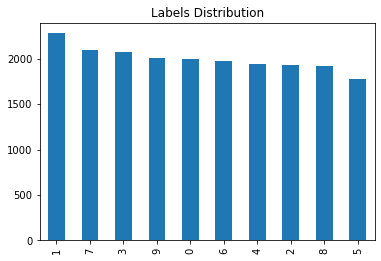

In [6]:
y_train.value_counts(dropna=False).plot(kind='bar')
plt.title("Labels Distribution") 
plt.show()

Present some of the images:

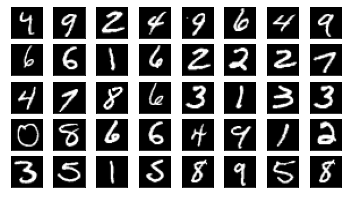

In [7]:
N=40
images= np.random.randint(low=0, high=600, size=N).tolist()

images = x_train.iloc[images,:]
# images.drop(columns=['label'], inplace=True)
images.index = range(1, N+1)

for i, row in images.iterrows():
    plt.subplot(N//8 + 1, 8, i)
    pixels = row.values.reshape((28,28))
    plt.imshow(pixels, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


## Part 1 - Clustering

### Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score


### Cluster

In [9]:
# it's here becuse we need to use later it in the next cells
class AgglomerativeClusteringPredict(AgglomerativeClustering):
    def predict(self, x_test, x_train):
        # Get the cluster assignments of the training data
        labels = self.labels_
        # Get the unique cluster labels
        unique_labels = np.unique(labels)
        # Get the centroids of the clusters
        centroids = np.array([np.mean(x_train[labels == k], axis=0) for k in unique_labels])
        # Calculate the distance between each new data point and the centroids
        dist = np.array([np.linalg.norm(x_test - c, axis=1) for c in centroids])
        # Assign each new data point to the closest centroid's cluster
        return unique_labels[np.argmin(dist, axis=0)]


In [10]:
def cluster_data(data, clustering_algorithm, hyperparams):
    """
    Cluster the input data using the specified clustering algorithm and hyperparameters.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm
    Returns:
    numpy array: cluster labels for each data point
    """    
    clustering_model = clustering_algorithm(**hyperparams)
    cluster_per_data_point = clustering_model.fit_predict(data)
    return clustering_model, cluster_per_data_point

### Visualize

In [11]:
def visualize_clusters(data, labels, n_clusters):
    """
    Visualize the clusters by displaying a few images from each cluster.
    Parameters:
    data (numpy array): input data to be clustered
    labels (numpy array): cluster labels for each data point
    n_clusters (int): number of clusters
    Returns:
    None
    """
    fig, ax = plt.subplots(n_clusters, 5, figsize=(8, 8))
    plt.title("Clusters and example images")
    for i in range(n_clusters):
        indices = np.where(labels == i)[0]
        for j in range(5):
            ax[i, j].imshow(data[indices[j]].reshape(28, 28), cmap='gray')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        ax[i, 0].set_ylabel(f'Cluster {i}', rotation=0, labelpad=20)
    plt.tight_layout()
    plt.show()


### Evaluation metrics

In [12]:
def evaluate_clustering(cluster_per_data_point, true_labels, data):
    """
    Evaluate the clustering result using three metrics: Silhouette score, completeness score,
    and homogeneity score.
    Parameters:
    cluster_per_data_point (numpy array): cluster labels for each data point
    true_labels (numpy array): true labels for each data point
    data (numpy array): input data to be clustered
    Returns:
    tuple: four clustering metrics: Silhouette score, completeness score, and homogeneity score.
    """
    silhouette_avg = silhouette_score(data, cluster_per_data_point)
    completeness_avg = completeness_score(true_labels, cluster_per_data_point)
    homogeneity_avg = homogeneity_score(true_labels, cluster_per_data_point)
    return silhouette_avg, completeness_avg, homogeneity_avg

### Classification

In [13]:
def build_classifier_and_evaluate(data, cluster_per_data_point, true_labels, clustering_model, clustering_algorithm, x_test, y_test, verbose=False):
    """
    Builds a classifier based on majority vote within the cluster given the data and the data_clusters.
    Also evaluates the classifier using accuracy and F1 metrics.
    return: accuracy & F1
    
    Parameters:
    data (numpy array): input data of shape (N, num_pixels)
    cluster_per_data_point (numpy array): (N, 1)
    true_labels (array): the classes for each data point
    clustering_model: sklearn class such as kmeans
    Returns:
    tuple: accuracy, f1
    """
    # Assign a label to each cluster based on majority vote
    unique_clusters = np.unique(cluster_per_data_point)
    cluster_labels = np.zeros(len(unique_clusters), dtype=int)
    for i, cluster in enumerate(unique_clusters):
        mask = (cluster_per_data_point == cluster)
        digit_counts = np.bincount(true_labels[mask])
        cluster_labels[i] = np.argmax(digit_counts)
            
    # Predict the digit label of each test image based on its nearest cluster
    if clustering_algorithm == AgglomerativeClusteringPredict:
        cluster_labels_test = clustering_model.predict(x_test, x_train)
    else:
        cluster_labels_test = clustering_model.predict(x_test)
    y_pred = np.array([cluster_labels[cluster] for cluster in cluster_labels_test])
    y_test = y_test.astype(int)
    # Evaluate the classifier using accuracy and F1 metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, f1    


In [14]:

def run_pipeline(data, true_labels, clustering_algorithm, hyperparams, x_test, y_test, should_vis=True):
    """
    Run the clustering pipeline on the input data using the specified clustering algorithm and hyperparameters,
    and return four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm

    Returns:
    tuple: four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    """
    # Cluster the data
    clustering_model, cluster_per_data_point = cluster_data(data, clustering_algorithm, hyperparams)
    # Evaluate the clustering
    silhouette_avg, completeness_avg, homogeneity_avg = evaluate_clustering(cluster_per_data_point, true_labels, data)
    num_clusters = hyperparams['n_clusters'] if clustering_algorithm != GaussianMixture else hyperparams['n_components']
    if should_vis:
        visualize_clusters(data, cluster_per_data_point, num_clusters)
    acc, f1 = build_classifier_and_evaluate(data, cluster_per_data_point, true_labels, clustering_model, clustering_algorithm, np.array(x_test), y_test, verbose=should_vis)
    return silhouette_avg, completeness_avg, homogeneity_avg, acc, f1


### K Means

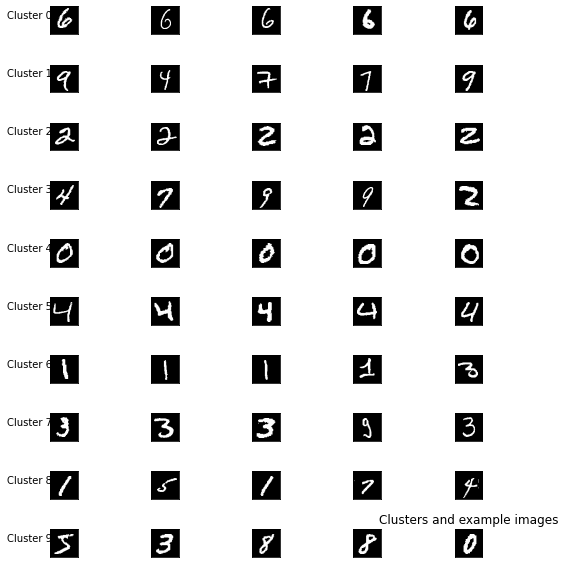

In [15]:
# init dict with clustering metrics
metrics_dict = {}

# KMEANS
n_clusters = len(set(y_train))
hyper_params = {'n_clusters': n_clusters}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, hyper_params, x_test, y_test)  
metrics_dict["kmeans_default"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



#### Num Iterations
As the default is 300

##### n = 100

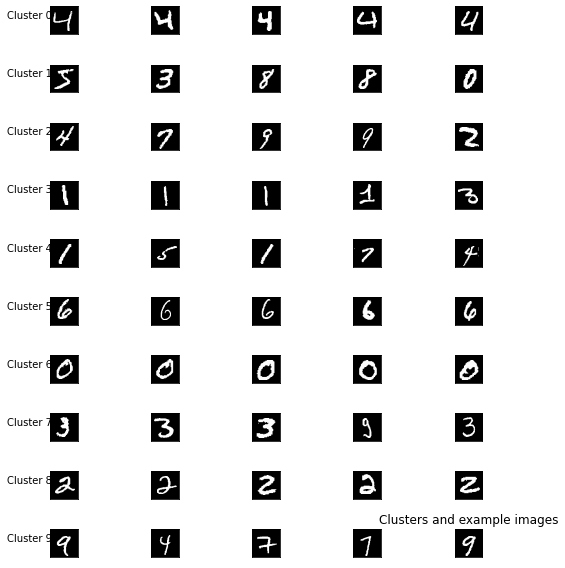

In [16]:
hyper_params = {'n_clusters': n_clusters, 'max_iter': 100}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, hyper_params, x_test, y_test)  
metrics_dict["kmeans_n_iters_100"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



##### n = 1000

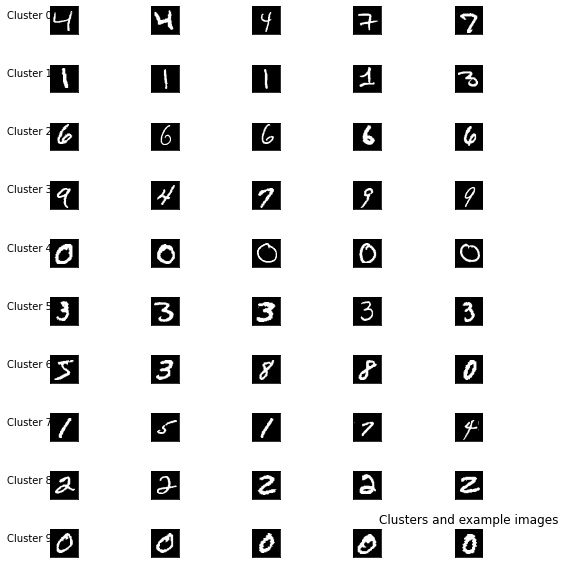

In [17]:
hyper_params = {'n_clusters': n_clusters, 'max_iter': 1_000}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, hyper_params, x_test, y_test)  
metrics_dict["kmeans_n_iters_1_000"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



#### Initiations

##### K Means ++

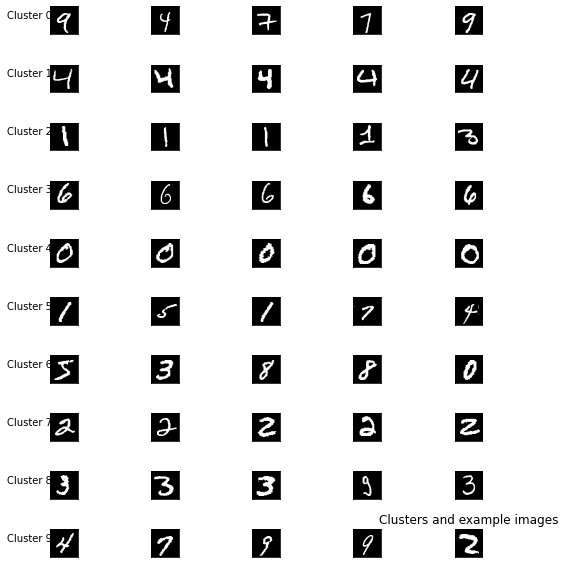

In [18]:
k_mean_plus_hyper_params = {'n_clusters': n_clusters, 'init': 'k-means++'}

silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, k_mean_plus_hyper_params, x_test, y_test)  

metrics_dict["kmeans++"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


### Agglomerative Clustering

In [19]:
class AgglomerativeClusteringPredict(AgglomerativeClustering):
    def predict(self, x_test, x_train):
        # Get the cluster assignments of the training data
        labels = self.labels_
        # Get the unique cluster labels
        unique_labels = np.unique(labels)
        # Get the centroids of the clusters
        centroids = np.array([np.mean(x_train[labels == k], axis=0) for k in unique_labels])
        # Calculate the distance between each new data point and the centroids
        dist = np.array([np.linalg.norm(x_test - c, axis=1) for c in centroids])
        # Assign each new data point to the closest centroid's cluster
        return unique_labels[np.argmin(dist, axis=0)]


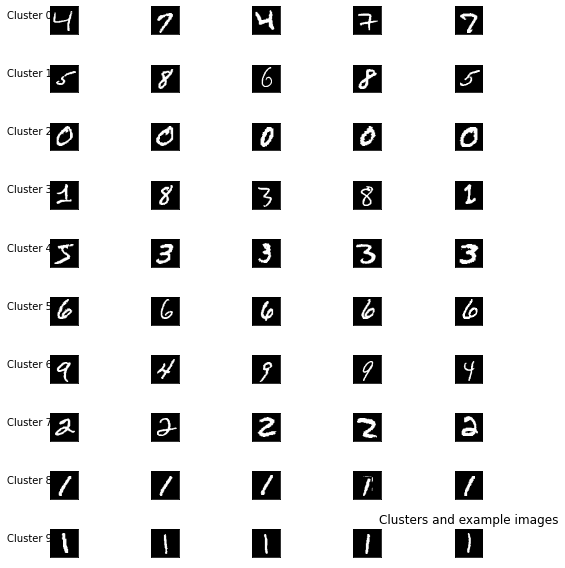

In [20]:
agg_hyper_params = {'n_clusters': 10}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test)  

metrics_dict["agglomerative_default"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


#### Distance Metric

##### L1 Distance

In [21]:
agg_hyper_params = {'n_clusters': 10, 'metric':'manhattan', 'linkage': 'single'}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test, should_vis=False)  

metrics_dict["agglomerative_l1"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


TypeError: __init__() got an unexpected keyword argument 'metric'

##### Manhatten distance

In [ ]:
agg_hyper_params = {'n_clusters': 10, 'metric':'manhattan', 'linkage': 'single'}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test, should_vis=False)  

metrics_dict["agglomerative_manhattan"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



#### Linkage

##### Complete

In [ ]:
agg_hyper_params = {'n_clusters': 10, 'linkage': 'complete'}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test, should_vis=False)  

metrics_dict["agglomerative_complete_linkage"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



##### Average

In [ ]:
agg_hyper_params = {'n_clusters': 10, 'linkage': 'average'}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test, should_vis=False)  

metrics_dict["agglomerative_average_linkage"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



#### GMM

In [ ]:
gmm_hyper_params = {
    'n_components': 10,
}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, GaussianMixture, gmm_hyper_params, x_test, y_test, should_vis=True)

metrics_dict["gmm_10_componets"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


##### Initiations

###### K Means ++

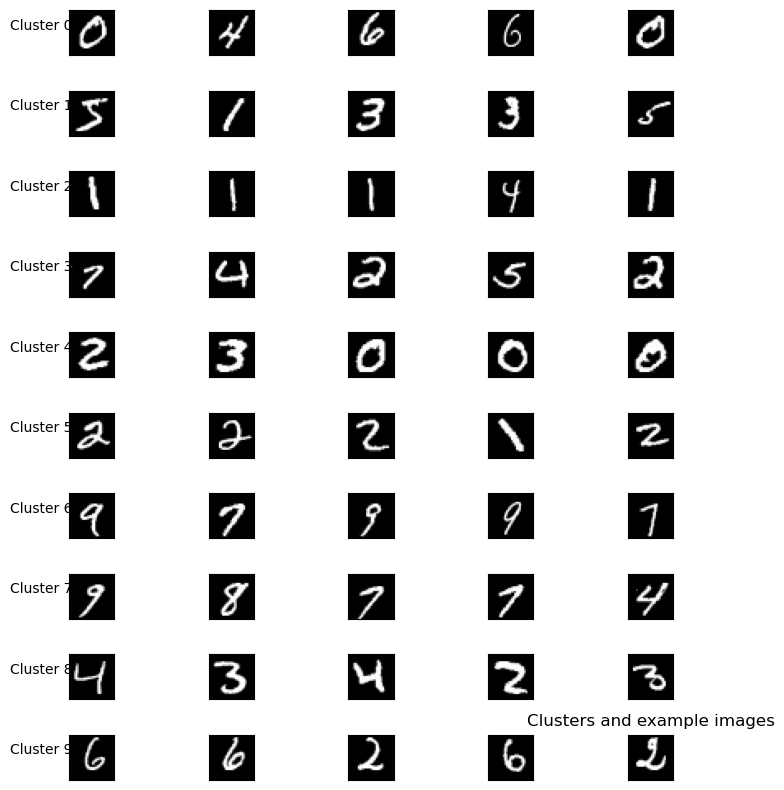

In [ ]:
gmm_hyper_params = {
    'n_components': 10,
    'init_params': 'k-means++'
}

silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, GaussianMixture, gmm_hyper_params, x_test, y_test, should_vis=True)

metrics_dict["gmm_kmeans++"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


##### Mixture components

###### n = 20

In [ ]:
gmm_hyper_params = {
    'n_components': 20,
}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, GaussianMixture, gmm_hyper_params, x_test, y_test, should_vis=False)

metrics_dict["gmm_20_componets"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


###### n = 50

In [ ]:
gmm_hyper_params = {
    'n_components': 50,
}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, GaussianMixture, gmm_hyper_params, x_test, y_test, should_vis=False)

metrics_dict["gmm_50_componets"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


#### Results

In [23]:
clustering_metrics_df = pd.DataFrame(metrics_dict).T
clustering_metrics_df

,silhouette_avg,completeness_avg,homogeneity_avg,acc,f1
kmeans_default,0.058097,0.477785,0.474257,0.5761,0.552108
kmeans_n_iters_100,0.057693,0.479914,0.476294,0.5759,0.552102
kmeans_n_iters_1_000,0.060377,0.491174,0.478465,0.5860,0.532641
kmeans++,0.058053,0.478099,0.474591,0.5760,0.551998
agglomerative_default,0.020213,0.650733,0.621644,0.5971,0.575553


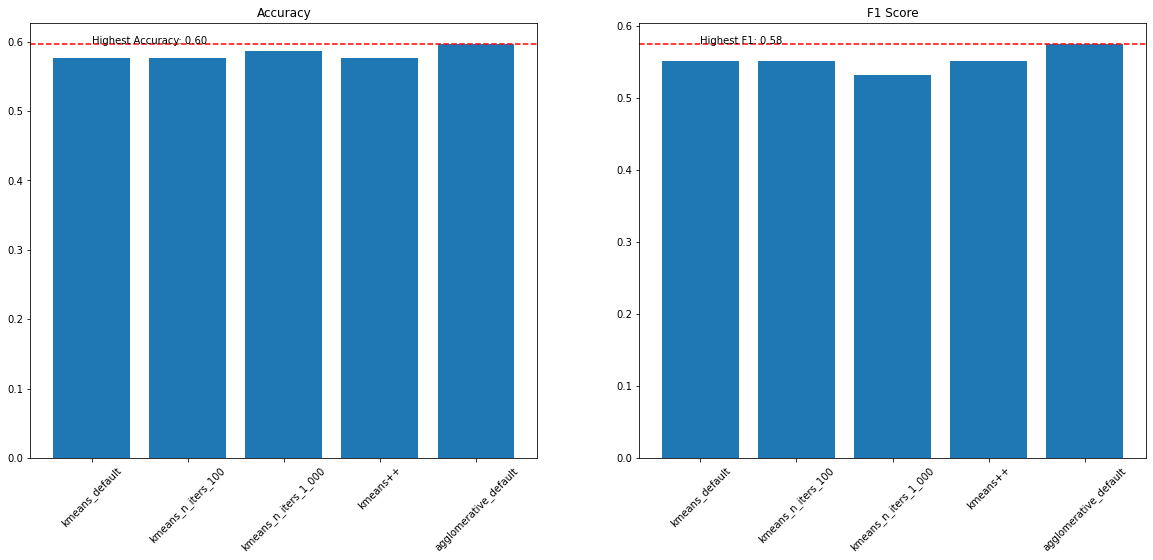

In [48]:
# plot the accuracy and f1 score for each clustering algorithm
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.bar(clustering_metrics_df.index, clustering_metrics_df["acc"])
plt.xticks(rotation=45)
# mark the model with highest accuracy
plt.axhline(y=clustering_metrics_df["acc"].max(), color='r', linestyle='--')
plt.text(0, clustering_metrics_df["acc"].max(), "Highest Accuracy: {:.2f}".format(clustering_metrics_df["acc"].max()))

# F1 plot
plt.subplot(1, 2, 2)
plt.title("F1 Score")
plt.bar(clustering_metrics_df.index, clustering_metrics_df["f1"])
plt.xticks(rotation=45)

# mark the model with highest f1
plt.axhline(y=clustering_metrics_df["f1"].max(), color='r', linestyle='--')
plt.text(0, clustering_metrics_df["f1"].max(), "Highest F1: {:.2f}".format(clustering_metrics_df["f1"].max()))

plt.show()

## Dimensionality Reduction

### Imports

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression

### Reduce Dimensions

In [36]:
def reduce_dimensions(X_train, X_test, model, hyper_params_dict):
    """
    Why am i using the concat of the train and test set before applying the dimensionality reduction?
    https://stackoverflow.com/questions/52849890/how-to-implement-t-sne-in-a-model
    """
    X_concat = np.concatenate((X_train, X_test))
    model = model(**hyper_params_dict)
    new_X_concat = model.fit_transform(X_concat)
    new_X_train = new_X_concat[:X_train.shape[0]]
    new_X_test = new_X_concat[X_train.shape[0]:]
    return new_X_train, new_X_test


### Visualize

In [37]:
def visualize(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y.astype(int), cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


In [38]:
# define a function to train a logistic regression classifier and evaluate its performance
def train_classifier_and_evaluate(X_train, y_train, X_test, y_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1


### Classification

In [39]:
def train_classifier_and_evaluate(X_train, y_train, X_test, y_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1


In [40]:
def main_dimenstionality_reduction(X_train, y_train, X_test, y_test, model, hyper_params_dict, visualize_pc=False):
    new_X_train, new_X_test = reduce_dimensions(X_train, X_test, model, hyper_params_dict)
    if visualize_pc:
        visualize(new_X_train, y_train)
    accuracy, f1 = train_classifier_and_evaluate(new_X_train, y_train, new_X_test, y_test)
    return accuracy, f1


In [41]:
dimensionality_reduction_metrics_dict = {}

### PCA

#### Embeded Space Dims

##### n = 2

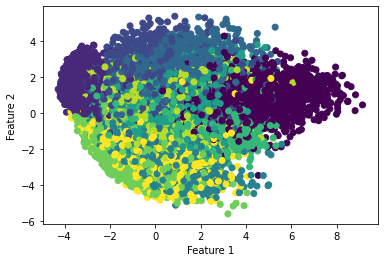

In [42]:
hyper_params_dict = {
    "n_components": 2
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, PCA, hyper_params_dict, visualize_pc=True)
dimensionality_reduction_metrics_dict["pca_2_components"] = dict(zip(["acc", "f1"], [acc, f1]))


##### n = 5

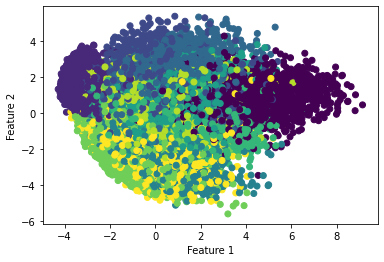

In [43]:
hyper_params_dict = {
    "n_components": 5
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, PCA, hyper_params_dict, visualize_pc=True)
dimensionality_reduction_metrics_dict["pca_5_components"] = dict(zip(["acc", "f1"], [acc, f1]))


##### n = 10

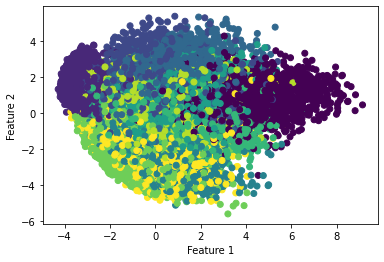

In [44]:
hyper_params_dict = {
    "n_components": 10
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, PCA, hyper_params_dict, visualize_pc=True)
dimensionality_reduction_metrics_dict["pca_10_components"] = dict(zip(["acc", "f1"], [acc, f1]))


### TSNE

#### Embeded Space Dims

##### n = 2

/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


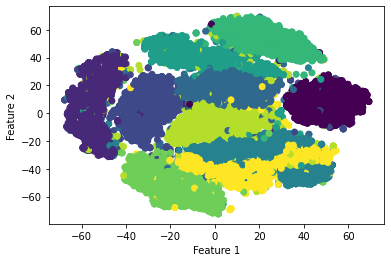

/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
hyper_params_dict = {
    "n_components": 2,
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, TSNE, hyper_params_dict, visualize_pc=True)
dimensionality_reduction_metrics_dict["tsne_2_componets"] = dict(zip(["acc", "f1"], [acc, f1]))


##### n = 3

/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


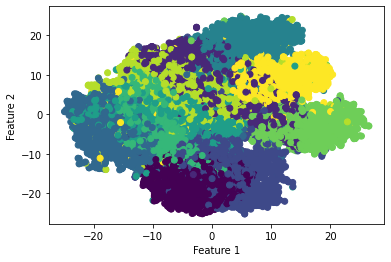

/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
hyper_params_dict = {
    "n_components": 3,
    }
acc, f1 = main_dimenstionality_reduction(x_train, y_train, x_test, y_test, TSNE, hyper_params_dict, visualize_pc=True)
dimensionality_reduction_metrics_dict["tsne_3_componets"] = dict(zip(["acc", "f1"], [acc, f1]))


### MDS

#### Embeded Space Dims

Note: because of run-time, we reduced the samples to 5000 instead of 20k for the training & test sets.

##### n = 2

In [52]:
hyper_params_dict = {
    'n_components': 2,
    'n_init': 1
}
acc, f1 = main_dimenstionality_reduction(x_train[:5000], y_train[:5000], x_test[:5000], y_test[:5000], MDS, hyper_params_dict, visualize_pc=False)

dimensionality_reduction_metrics_dict["MDS_2_componets"] = dict(zip(["acc", "f1"], [acc, f1]))


##### n = 5

In [53]:
hyper_params_dict = {
    'n_components': 5,
    'n_init': 1
}
acc, f1 = main_dimenstionality_reduction(x_train[:5000], y_train[:5000], x_test[:5000], y_test[:5000], MDS, hyper_params_dict, visualize_pc=False)
dimensionality_reduction_metrics_dict["MDS_5_componets"] = dict(zip(["acc", "f1"], [acc, f1]))


/mnt/raid/home/eyal_michaeli/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### n = 10

In [54]:
hyper_params_dict = {
    'n_components': 10,
    'n_init': 1
}
acc, f1 = main_dimenstionality_reduction(x_train[:5000], y_train[:5000], x_test[:5000], y_test[:5000], MDS, hyper_params_dict, visualize_pc=False)
dimensionality_reduction_metrics_dict["MDS_10_componets"] = dict(zip(["acc", "f1"], [acc, f1]))


In [55]:
dimensionality_reduction_metrics_df = pd.DataFrame(dimensionality_reduction_metrics_dict).T
dimensionality_reduction_metrics_df

,acc,f1
pca_2_components,0.4455,0.396672
pca_5_components,0.6857,0.682514
pca_10_components,0.8097,0.809208
tsne_2_componets,0.8673,0.865027
tsne_3_componets,0.9459,0.945844
MDS_2_componets,0.2724,0.210535
MDS_5_componets,0.5676,0.542034
MDS_10_componets,0.7208,0.719879


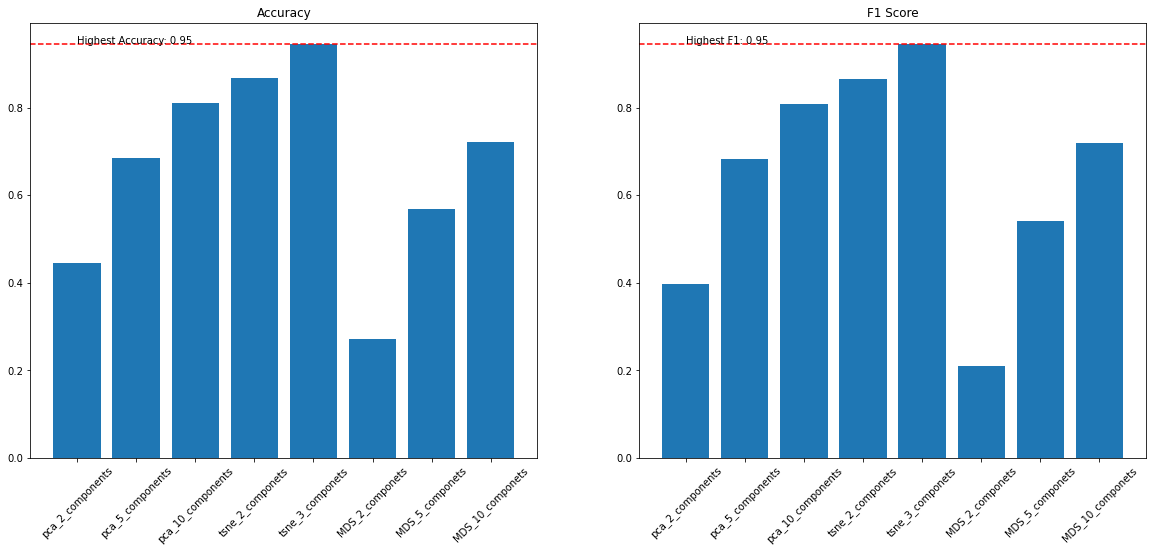

In [56]:
# plot the accuracy and f1 score for each clustering algorithm
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.bar(dimensionality_reduction_metrics_df.index, dimensionality_reduction_metrics_df["acc"])
plt.xticks(rotation=45)
# mark the model with highest accuracy
plt.axhline(y=dimensionality_reduction_metrics_df["acc"].max(), color='r', linestyle='--')
plt.text(0, dimensionality_reduction_metrics_df["acc"].max(), "Highest Accuracy: {:.2f}".format(dimensionality_reduction_metrics_df["acc"].max()))

# F1 plot
plt.subplot(1, 2, 2)
plt.title("F1 Score")
plt.bar(dimensionality_reduction_metrics_df.index, dimensionality_reduction_metrics_df["f1"])
plt.xticks(rotation=45)

# mark the model with highest f1
plt.axhline(y=dimensionality_reduction_metrics_df["f1"].max(), color='r', linestyle='--')
plt.text(0, dimensionality_reduction_metrics_df["f1"].max(), "Highest F1: {:.2f}".format(dimensionality_reduction_metrics_df["f1"].max()))

plt.show()

## Classification of the raw data

### Imports

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

### Classification with SVM

In [58]:
param_grid = {'C': [0.1, 1, 10]}

svm = SVC(kernel='rbf')

grid_search = GridSearchCV(svm, param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

classification_results_df = pd.DataFrame(columns=['C', 'acc', 'f1'])
for i, params in enumerate(grid_search.cv_results_['params']):
    clf = SVC(kernel='rbf', **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    classification_results_df.loc[i] = [params['C'], accuracy, f1]
    
    
# get the best model metrics from the classification_results_df
best_classification_results_df = classification_results_df.loc[classification_results_df['acc'].idxmax()][['acc', 'f1']]
best_classification_results_df

acc    0.976700
f1     0.976531
Name: 2, dtype: float64

In [ ]:
classification_results_df.set_index('C', inplace=True)
# convert the index to string
classification_results_df.index = classification_results_df.index.map(str)
# add 'svm_' prefix to the index
classification_results_df.index = 'svm_' + classification_results_df.index
classification_results_df

## Summary

In [ ]:
df_concat = pd.concat([clustering_metrics_df.loc[:, ['acc', 'f1']], dimensionality_reduction_metrics_df.loc[:, ['acc', 'f1']], best_classification_results_df.loc[:, ['acc', 'f1']]])
df_concat

In [ ]:
# plot the accuracy and f1 score for each clustering algorithm
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.bar(df_concat.index, df_concat["acc"])
plt.xticks(rotation=45)
# mark the model with highest accuracy
plt.axhline(y=df_concat["acc"].max(), color='r', linestyle='--')
plt.text(0, df_concat["acc"].max(), "Highest Accuracy: {:.2f}".format(df_concat["acc"].max()))

# F1 plot
plt.subplot(1, 2, 2)
plt.title("F1 Score")
plt.bar(df_concat.index, df_concat["f1"])
plt.xticks(rotation=45)

# mark the model with highest f1
plt.axhline(y=df_concat["f1"].max(), color='r', linestyle='--')
plt.text(0, df_concat["f1"].max(), "Highest F1: {:.2f}".format(df_concat["f1"].max()))

plt.show()
